In [13]:
import sys
import subprocess
import json
import os
import matplotlib.pyplot as plt
from functools import reduce


sys.path.append(os.path.abspath("../generation"))
import generate
from parseRePEAT import *

In [14]:
def plot_atf(segments, label, color, eatfs, fig, axs):
    line = None
    for (x0, x1, y0, y1) in segments:
        if x0 == "-inf" and x1 != "inf" and y1 != "inf":
            axs[0].hlines(float(y1), 0, float(x1), colors=color)
        line, = axs[0].plot([float(x0), float(x1)], [float(y0), float(y1)], color=color)
    line.set_label(label) if line is not None else None

    for (zeta, alpha, beta, delta, gammas) in list(eatfs.values())[0]:
        min_gammas = [float(gamma[0]) for gamma in gammas]
        min_gamma = sum(min_gammas)

        length_edge = float(beta)-float(alpha)
        max_gammas = [min(float(gamma[1]), length_edge + float(gamma[0])) for gamma in gammas]
        max_gamma = sum(max_gammas)
        axs[1].plot([float(alpha), float(beta)], [min_gamma, max_gamma], color=color)
        # axs[1].plot([float(alpha), float(beta)], [min_gammas, max_gammas], color=color)

        print(f"{alpha}, {beta}, {gammas}, {min_gamma} - {max_gamma}")

def generate_intervals(max_delay, layout, scenario, agent, agent_speed, move, fig, axs, color):
    # Generate intervals
    # generate.time_safe_intervals_and_write(layout, scenario, agent["trainNumber"], agent_speed, "output", max_delay)
    generate.time_safe_intervals_and_write(layout, scenario, -1, 30, "output", max_delay)
    # start = "r-n3_2" if agent["trainNumber"] == 1 else "t-n3_1"
    start = "r-n3_2"
    timeout = 60
    try:
        # proc = subprocess.run(["atsipp.exe", "--start", start, "--goal", "r-14", "--edgegraph", "output", "--search", "repeat", "--startTime", str(move["startTime"])], timeout=20, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)
        proc = subprocess.run(["Y:/Uni/Thesis/executable/atsipp.exe", "--start", "r-n3_2", "--goal", "r-14", "--edgegraph", "output", "--search", "repeat", "--startTime", "0"], timeout=timeout, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)

    except subprocess.TimeoutExpired:
        print(f'Timeout for repeat ({timeout}s) expired')
        return
    repeat_output = str(proc.stdout).split("'")[1].rsplit("\\r\\n")

    # If the run was successful
    if int(proc.returncode) == 0:
        metadata, catf, paths, eatfs = parse_list_of_outputs(repeat_output)
        # print(f"eats: {eatfs}")
        # print(f"cats: {catf}")
        label = f"{max_delay}s buffer time" if max_delay > 0 else "No flexibility"
        plot_atf(catf, label, color, eatfs, fig, axs)

0, 45, [['0', '0'], ['0', '0'], ['0', '0'], ['0', '0'], ['0', '0']], 0.0 - 0.0
45, 58.3333, [['0', '0'], ['0', '13.3333'], ['0', '0'], ['0', '0'], ['0', '0']], 0.0 - 13.3333
58.3333, 63.3333, [['0', '0'], ['13.3333', '18.3333'], ['0', '0'], ['0', '0'], ['0', '0']], 13.3333 - 18.3333
63.3333, 76.6667, [['0', '0'], ['18.3333', '31.6667'], ['0', '0'], ['0', '0'], ['0', '0']], 18.3333 - 31.6667
76.6667, 495, [['0', '0'], ['31.6667', '450'], ['0', '0'], ['0', '0'], ['0', '0']], 31.6667 - 450.0
248, 495, [['0', '0'], ['203', '450'], ['0', '0'], ['0', '0'], ['0', '0']], 203.0 - 450.0
364.667, 495, [['0', '0'], ['319.667', '450'], ['0', '0'], ['0', '0'], ['0', '0']], 319.667 - 450.0
381.333, 595, [['0', '0'], ['0', '0'], ['0', '0'], ['0', '0'], ['0', '0']], 0.0 - 0.0
595, 608.333, [['0', '0'], ['0', '0'], ['1.13687e-13', '13.3333'], ['0', '0'], ['0', '0']], 1.13687e-13 - 13.333000000000084
608.333, 613.333, [['0', '0'], ['0', '0'], ['13.3333', '18.3333'], ['0', '0'], ['0', '0']], 13.3333 - 18.

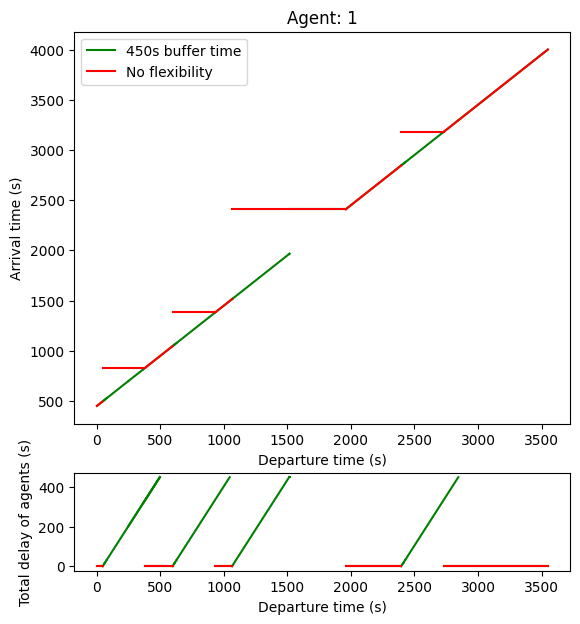

In [15]:
# Run RePeAT to get multiple plans
scenario = "../data/single_track/scenario_following.json"
layout =   "../data/single_track/woho.json"

scenario_data = json.load(open(scenario))
train_types = {x["name"]: x for x in scenario_data["types"]}
for agent in scenario_data['trains']:
    # Get the global end time of scenario
    scenario_end_time = 0
    for i in range(len(agent["movements"])):
        move = agent["movements"][i]
        if 2 * move["endTime"] > scenario_end_time:
            scenario_end_time = 2 * move["endTime"]
    agent_speed = train_types[agent["trainUnitTypes"][0]]["speed"] * 1.09
    # agent_speed = 60
    for move in agent["movements"]:
        fig, axs = plt.subplots(2, gridspec_kw={"height_ratios": [4, 1]})

        # Difference
        generate_intervals(450, layout, scenario, agent, agent_speed, move, fig, axs, color="green")
        # generate_intervals(300, layout, scenario, agent, agent_speed, move, color="blue")

        # baseline
        generate_intervals(0,   layout, scenario, agent, agent_speed, move, fig, axs, color="red")

        title = f"Agent: {agent['trainNumber']}"
        axs[0].set_xlabel("Departure time (s)")
        axs[1].set_xlabel("Departure time (s)")
        axs[0].set_ylabel("Arrival time (s)")
        axs[1].set_ylabel("Total delay of agents (s)")
        axs[0].set_title(title)
        axs[0].legend()
        fig.set_figheight(7)
        plt.show()
    break

